# Generate potential temperature forcing file ("pt_interior_data")
* This code generates monthly potential temperature forcing file for POP2. I took the monthly output from the control simulation ("C compset"), and imposed an potential temperature anomaly in specific depths over the Labrador Sea.
* The definition of Labrador Sea follows regionmask (see https://regionmask.readthedocs.io/en/stable/).
* The forcing is designed as follows.
$$
T_{forcing}=Acos(\frac{z-z_c}{d}\pi),\quad z_c-\frac{d}{2}<z<z_c+\frac{d}{2}
$$
$z_c$: mid point of the forcing \
$d$: range of the depths \
$A$: forcing amplitude

* Note that the model needs the variable name to be "TEMPERATURE 1", "TEMPERATURE 2", ......, "TEMPERATURE12", with the space padded in months 1-9. See line 359 in forcing_pt_interior.F90, that it requires the format as '(a11,i2)'. Also see similar questions raised in CESM forum (https://bb.cgd.ucar.edu/cesm/threads/how-to-write-a-nc-file-to-in-forcing_pt_interior_nml-in-pop2-namelist.2853/post-12572).
* Note that the surface potential temperature will not be restored based on the original source code (line 720 in forcing_pt_interior.F90), so it is called "pt_interior_data".
* For more information, see Lin et al. (2022).

In [1]:
import netCDF4 as nc
import regionmask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
z_finegrid = np.arange(0.,6001.,5.) #(m)
def cos_in_bounds(A, z_upper, z_lower, zc, d):
    z1 = z_finegrid.copy()
    z2 = z1.copy()
    z2[np.logical_or(z1<z_upper, z1>z_lower)]=np.nan
    return A*np.cos(np.pi*(z2-zc)/d)
def covert_to_z_t(cos_out):
    f = interp1d(z_finegrid, cos_out)
    return f(z_t_SI.values)

### Control Panel
- How to change the depth of the forcing?
Set a list of $z_c$ (`zc_list`)
- How to change the cosine shape of the forcing?
`d` and `A`
- How to run ensembles?
Change the `c_year`: the year branched from the control simulation. It is also the year that we used as the background potential temperaure: $T_{control}$ in the equation (5.2) in Lin et al. (2022).

In [3]:
c_name            = 'C_128cores' # the name of control run
c_year            = '0291' # the year that is branched from the control simulation (so is also the year as background potential temperature) # make ensembles by adjusting this

zc_list           = np.array((250.,500.,750.,1000.,1250.,1500.)) # (m)
d                 = 500. # (m)
A                 = 1. # (degC)

check_z_t_value   = False # True and it shows z_t value at each level
save_file         = False # True if you do want to save the file. False if you just wanna get the data

In [4]:
with xr.open_mfdataset('/data/rose_scr/yl528729/cesmruns/'+c_name+'/run/'+c_name+'.pop.h.'+c_year+'-01.nc', chunks={'time': 3}, combine='by_coords') as ds:    
    TLONG_da             = ds['TLONG'] # "array of t-grid longitudes" # (nlat, nlon)
    TLAT_da              = ds['TLAT'] # "array of t-grid latitudes" # (nlat, nlon)
    z_t_da               = ds['z_t'] # [cm] # "depth from surface to midpoint of layer"
    dz_da                = ds['dz'] # [cm] # "thickness of layer k" (z_t)
    TAREA_da             = ds['TAREA'] # [cm2] # "area of T cells" # (nlat, nlon)
    KMT_da               = ds['KMT'] # "k Index of Deepest Grid Cell on T Grid" # (nlat, nlon)
    rho_sw               = ds['rho_sw'].values # [g/cm3] # sea water density
    cp_sw                = ds['cp_sw'].values # [erg/g/K] # Specific Heat of Sea Water
z_t_SI   = z_t_da/1e2 # [cm->m]
dz_SI    = dz_da/1e2 # [cm->m]
TAREA_SI = TAREA_da/1e4 # [cm2->m2]
rho_sw_SI= rho_sw*1e3 # [g/cm3->kg/m3]
cp_sw_SI = cp_sw*1e3*1e-7 # [erg/g/K->J/kg/K]

In [5]:
basins          = regionmask.defined_regions.natural_earth.ocean_basins_50
mask            = basins.mask(TLONG_da, TLAT_da)
mask_LBD        = (mask==19) 

### Main code for generating the forcing file

In [6]:
for zc in zc_list:
    z_upper           = zc-d/2
    z_lower           = zc+d/2

    forcing     = cos_in_bounds(A,z_upper,z_lower,zc,d)
    forcing_z   = covert_to_z_t(forcing)
    forcing_out = np.where(np.isnan(forcing_z),0.,forcing_z)

    if save_file:
        out_filename = '/network/rit/lab/roselab_rit/ylin/input_made/TEMP_LBD_ZC'+'{:04d}'.format(int(zc))+'_D'+'{:04d}'.format(int(d))+'_A'+'{:02d}'.format(int(A))+'_'+c_name+'_Y'+c_year+'.nc'
        print(out_filename)
        out_ds = nc.Dataset(out_filename, 'w', format='NETCDF4')
        out_ds.createDimension('z_t', z_t_da.shape[0])
        out_ds.createDimension('nlat', TLAT_da.shape[0])
        out_ds.createDimension('nlon', TLONG_da.shape[1])

        # z_t    = out_ds.createVariable('z_t', np.float32, ('z_t',))
        z_t    = out_ds.createVariable('z_t', 'd', ('z_t',))
        TLONG  = out_ds.createVariable('TLONG', 'd', ('nlat','nlon'))
        TLAT   = out_ds.createVariable('TLAT', 'd', ('nlat','nlon'))

        z_t.long_name = z_t_da.attrs['long_name']
        z_t.units     = z_t_da.attrs['units']
        z_t.positive  = z_t_da.attrs['positive']
        z_t.valid_min = z_t_da.attrs['valid_min']
        z_t.valid_max = z_t_da.attrs['valid_max']

        TLONG.long_name = TLONG_da.attrs['long_name']
        TLONG.units     = TLONG_da.attrs['units']

        TLAT.long_name = TLAT_da.attrs['long_name']
        TLAT.units     = TLAT_da.attrs['units']

        z_t[:]    = z_t_da.values
        TLONG[:]  = TLONG_da.values
        TLAT[:]   = TLAT_da.values

    for imon in range(1,13):
        in_filename = '/data/rose_scr/yl528729/cesmruns/'+c_name+'/run/'+c_name+'.pop.h.'+c_year+'-'+'{:02d}'.format(imon)+'.nc'
        # print(in_filename)
        with xr.open_mfdataset(in_filename, chunks={'time': 3}, combine='by_coords') as ds:    
                TEMP_da = ds['TEMP'] # [degC] # "Potential Temperature" # (z_t: 60, nlat: 384, nlon: 320) # coordinates = "TLONG TLAT z_t"
        TEMP_val                  = TEMP_da.values[0,...] # you don't need that extra time dimension
        mask_LBD_val              = mask_LBD.values

        forcing_out_, mask_LBD_val_        = np.broadcast_arrays(forcing_out[:,np.newaxis,np.newaxis], mask_LBD_val[np.newaxis,...])
        forcing_LBD                        = forcing_out_.copy()
        forcing_LBD[mask_LBD_val_==False]  = 0.
        TEMP_LBD                           = TEMP_val.copy()
        TEMP_LBD                          += forcing_LBD

        if save_file:
            TEMP_mon              = out_ds.createVariable('TEMPERATURE'+str(imon).rjust(2), 'd', ('z_t','nlat','nlon')) 
            TEMP_mon.long_name    = TEMP_da.attrs['long_name']
            TEMP_mon.units        = TEMP_da.attrs['units']
            TEMP_mon.grid_loc     = TEMP_da.attrs['grid_loc']
            TEMP_mon.cell_methods = TEMP_da.attrs['cell_methods']
            TEMP_mon[:]           = TEMP_LBD

    if save_file:
        out_ds.close() 

### Plotting the figure that shows the forcing profile in each simulation

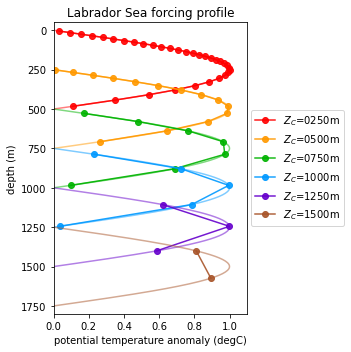

In [7]:
fc = {}
fcz = {}
fcz_out = {}
for zc in zc_list:
    z_upper = zc-d/2
    z_lower = zc+d/2
    fc[str(int(zc))]      = cos_in_bounds(A,z_upper,z_lower,zc,d)
    fcz[str(int(zc))]     = covert_to_z_t(fc[str(int(zc))])
    fcz_out[str(int(zc))] = np.where(np.isnan(fcz[str(int(zc))]),0.,fcz[str(int(zc))])

plt.figure(figsize=(5,5))
plt.plot(fc['250'],z_finegrid,c=(1,0,0,0.5),label='_nolegend_')
plt.plot(fcz['250'],z_t_SI,'-o',c=(1,0,0,0.9))
plt.plot(fc['500'],z_finegrid,c=(1,0.6,0,0.5),label='_nolegend_')
plt.plot(fcz['500'],z_t_SI,'-o',c=(1,0.6,0,0.9))
plt.plot(fc['750'],z_finegrid,c=(0,0.7,0,0.5),label='_nolegend_')
plt.plot(fcz['750'],z_t_SI,'-o',c=(0,0.7,0,0.9))
plt.plot(fc['1000'],z_finegrid,c=(0,0.6,1,0.5),label='_nolegend_')
plt.plot(fcz['1000'],z_t_SI,'-o',c=(0,0.6,1,0.9))
plt.plot(fc['1250'],z_finegrid,c=(0.4,0,0.8,0.5),label='_nolegend_')
plt.plot(fcz['1250'],z_t_SI,'-o',c=(0.4,0,0.8,0.9))
plt.plot(fc['1500'],z_finegrid,c=(0.66,0.33,0.16,0.5),label='_nolegend_')
plt.plot(fcz['1500'],z_t_SI,'-o',c=(0.66,0.33,0.16,0.9))
plt.ylim((-50,1800))
plt.yticks(np.arange(0,1751,250))
plt.xlim((0,1.1))
plt.gca().invert_yaxis()
plt.title('Labrador Sea forcing profile')
plt.xlabel('potential temperature anomaly (degC)')
plt.ylabel('depth (m)')
plt.legend([r'$Z_C$=0250m',r'$Z_C$=0500m',r'$Z_C$=0750m',r'$Z_C$=1000m',r'$Z_C$=1250m',r'$Z_C$=1500m'],bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0., fontsize=10)
plt.tight_layout()
plt.savefig('/network/rit/home/yl528729/figs/Forcing_profile.svg',transparent=True)  